In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import nltk
from arabica import arabica_freq
from unidecode import unidecode
import re
import plotly.express as px
import texthero as hero
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import BernoulliNB
import spacy
import re
import nlp
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols


warnings.simplefilter(action='ignore', category=FutureWarning)

2023-09-18 15:14:21.753400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:14:22.070955: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:14:22.073220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 15:14:23.645041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('sentimento - base2.csv')

In [3]:
df.head()

,id_issue,mes_chat,SENTIMENTO,TIPO_MSG,hierarquia_4,ds_cluster_sociodemographic,ds_message,flag_negativo_indecx
0,15388962,2023-04-01,neutro,duvida,Vencimento fatura,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...","['Que dia minha fatura fecha?','Ainda tenho dú...",0
1,17497395,2023-07-01,neutro,duvida,Dúvidas sobre pagamento de fatura,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...","['Quero pagar os 100 reais que eu tirei','Mais...",0
2,15213047,2023-04-01,neutro,solicitacao,Não reconhecimento de compra no crédito,"17 - Mulher, 25 a 40 anos, Sudeste e Sul","['Apareceu uma compra que eu não fiz','Dúvida ...",0
3,17117301,2023-06-01,neutro,problema,Parcelamento de fatura,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",['No meu limite está escrito que está utilizad...,0
4,17345996,2023-07-01,negativo,problema,Dúvidas PIX,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...","['Pix','E merda o will nunca teve essas coisas...",0


In [4]:
df['ds_message'][4]

"['Pix','E merda o will nunca teve essas coisas','Estou precisando fazer o pix e não estou conseguindo','desde ontem','Não dá pra fazer Pix','Mais opções']"

In [5]:
# def classif_emoji(text):
#     '''
#     Replace emojis with word emoji
#     '''
#     regrex_pattern = re.compile(pattern="["
#                                 u"\U0001F600-\U0001F64F"  # emoticons
#                                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                 "]+", flags=re.UNICODE)
#     return regrex_pattern.sub(r'emoji ', str(text))

def clean_text(x):
    x = unidecode(x)
    x = x.strip()
    x = x.lower()
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x


In [6]:
len(df)

14906

In [7]:
# não vou remover emojis
df['ds_message_tratada'] = df['ds_message'].apply(clean_text)

In [8]:
df['ds_message_tratada'][4]

"['pix' 'e merda o will nunca teve essas coisas' 'estou precisando fazer o pix e nao estou conseguindo' 'desde ontem' 'nao da pra fazer pix' 'mais opcoes']"

In [9]:
df['n_palavras'] = df['ds_message_tratada'].str.count(' ')

In [15]:
df['n_palavras_t'] = np.where(df.n_palavras >= 20, 20, df.n_palavras)

In [16]:
df.n_palavras_t.value_counts()

20    9338
9      417
13     386
17     377
12     360
14     358
19     350
6      349
15     341
16     334
11     328
18     318
10     300
8      297
5      283
7      269
4      184
2      106
3       93
1       69
0       49
Name: n_palavras_t, dtype: int64

In [17]:
pd.crosstab(df.n_palavras_t, df.SENTIMENTO)

SENTIMENTO,negativo,neutro,positivo
n_palavras_t,,,
4,1,1,0
5,0,3,1
6,0,7,0
7,0,4,0
8,0,4,0
9,0,7,0
10,0,1,1
11,1,6,0
12,1,4,0


In [30]:
exemplo_base = df[df['SENTIMENTO'].notnull()]
len(exemplo_base)

512

In [19]:
stopwords_will= ['da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce',
                 'pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um','como', 'meu', 'com', 'outro','outra','das','dos','foi', 'fiz','pelo','tem','mas',
            'este', 'esse','ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

In [31]:
#exemplo_base['ds_message'] = exemplo_base['ds_message'].fillna("").apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_will]))
## retirando sinais de pontuação
#exemplo_base['ds_message'] = exemplo_base['ds_message'].str.replace('[^\w\s]','')
## colocando todas as letras das mensagens em letras minúsculas
exemplo_base['ds_message'] = exemplo_base['ds_message'].str.lower() 

## Análise de sentimento
vetorizador = CountVectorizer()

X = vetorizador.fit_transform(exemplo_base['ds_message'])

#X = np.append(X, exemplo_base['n_palavras'])


y = exemplo_base.SENTIMENTO

clf = BernoulliNB()
clf = clf.fit(X,y)

def sentimentos(df, ds_message_tratada):
    df['sentimento_predict'] = clf.predict(vetorizador.transform(df[ds_message_tratada].fillna('')))
    return df

/tmp/ipykernel_312769/3812937011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
exemplo_base = sentimentos(exemplo_base, 'ds_message')

/tmp/ipykernel_312769/3812937011.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
exemplo_base.sentimento_predict.value_counts()

neutro      316
negativo    158
positivo     38
Name: sentimento_predict, dtype: int64

In [34]:
pd.crosstab(exemplo_base.sentimento_predict, exemplo_base.SENTIMENTO)

SENTIMENTO,negativo,neutro,positivo
sentimento_predict,,,
negativo,149,6,3
neutro,79,177,60
positivo,0,1,37


In [35]:
for i in exemplo_base.query('sentimento_predict == "neutro" & SENTIMENTO == "negativo"').head(10)['ds_message']:
    print(i)

['pix','e merda o will nunca teve essas coisas','estou precisando fazer o pix e não estou conseguindo','desde ontem','não dá pra fazer pix','mais opções']
['já passou do prazo e não recebi','que possa me atende?','tem alguém ai','pra me atender?','alguém ai?']
['falar de outra coisa','quero saber por que não entrou ainda o reembolso da shen.']
['quanto tempo pro estorno cair','estorno na fatura','problema com compra','fatura do cartão','esse tempo já passou','tô tentando manda o print só q ñ da certo','mostrar o exemplo']
['pix','todo dia da problema nesse aplicativo deus e mais','falar de outra coisa','não dá pra fazer pix']
['mudar endereço de entrega','responder mensagem de antes','tá em processo se entrega e nunca chega','falar de outra coisa','falta de respeito com o cliente','esse atendimento de vcs e péssimo']
['tá ok vou aguardar','cancelar essa conta pois tive meu limite bloqueado por falta de pagamento','já paguei minha dívida mais não liberaram mais o crédito por isso quero 

In [36]:
#Modelo de duvida, problema ou solicitacao

y = exemplo_base.TIPO_MSG

clf2 = BernoulliNB()
clf2 = clf2.fit(X,y)

def tipo_msg(df, ds_message_tratada):
    df['tipo_msg_predict'] = clf2.predict(vetorizador.transform(df[ds_message_tratada].fillna('')))
    return df

exemplo_base = tipo_msg(exemplo_base, 'ds_message')


/tmp/ipykernel_312769/3680250037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
exemplo_base.tipo_msg_predict.value_counts()

duvida         273
problema       184
solicitacao     55
Name: tipo_msg_predict, dtype: int64

In [38]:
pd.crosstab(exemplo_base.tipo_msg_predict, exemplo_base.TIPO_MSG)

TIPO_MSG,duvida,problema,solicitacao
tipo_msg_predict,,,
duvida,141,67,65
problema,7,164,13
solicitacao,0,2,53


In [39]:
for i in exemplo_base.query('tipo_msg_predict == "duvida" & TIPO_MSG == "problema"').head(10)['ds_message']:
    print(i)

['no meu limite está escrito que está utilizado 293,08 e o saldo disponível é de 67,92','não entendi esse valor de 293,08 porque eu paguei já 2 meses 200$ no cartão da wil banck','já paguei e tenho dúvidas']
['pix','e merda o will nunca teve essas coisas','estou precisando fazer o pix e não estou conseguindo','desde ontem','não dá pra fazer pix','mais opções']
['então','meu limite tá negativo ainda']
['já passou do prazo e não recebi','que possa me atende?','tem alguém ai','pra me atender?','alguém ai?']
['falar de outra coisa','quero saber por que não entrou ainda o reembolso da shen.']
['pix','todo dia da problema nesse aplicativo deus e mais','falar de outra coisa','não dá pra fazer pix']
['pix','fatura do cartão','não dá pra cadastrar chave','voltar pro começo']
['ainda preciso de ajuda.','certo','entendi  obrigada','parcelei minha fatura e já paguei com o saldo da conta e não voltou o limite ainda']
['gostaria de saber porque meu serviço will está indisponível no momento?','irei f

## Próximos passos

- Testar outros classificadores: xgboost, svm
- Testar outros vetorizadores com melhor modelo

In [42]:
exemplo_base['SENTIMENTO_label'] = np.where(exemplo_base['SENTIMENTO'] == "negativo", 0, 
                                            np.where(exemplo_base['SENTIMENTO'] == "neutro", 1, 2 ))

/tmp/ipykernel_312769/2720231541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
import xgboost as xgb
y = exemplo_base.SENTIMENTO_label
clf = xgb.XGBClassifier(objective="multi:softmax", random_state=42) #early_stopping_rounds=2
clf = clf.fit(X,y)

In [44]:
exemplo_base = sentimentos(exemplo_base, 'ds_message')

/tmp/ipykernel_312769/3812937011.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
pd.crosstab(exemplo_base.sentimento_predict, exemplo_base.SENTIMENTO_label)

SENTIMENTO_label,0,1,2
sentimento_predict,,,
0,228,0,0
1,0,184,0
2,0,0,100


In [46]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)


In [47]:
clf = xgb.XGBClassifier(objective="multi:softmax", random_state=42) #early_stopping_rounds=2
clf = clf.fit(x_train,y_train)

In [53]:
y_predicted = clf.predict(x_test)

In [54]:
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,36,11,5
1,7,26,7
2,3,0,8


In [66]:
## Análise de sentimento
vetorizador = TfidfVectorizer()

X = vetorizador.fit_transform(exemplo_base['ds_message'])

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

In [57]:
clf = xgb.XGBClassifier(objective="multi:softmax", random_state=42) 
clf = clf.fit(x_train,y_train)

In [58]:
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,37,10,6
1,5,26,3
2,4,1,11


In [68]:
X.shape[0]

512

In [69]:
exemplo_base.n_palavras.shape[0]

512

In [76]:
from sklearn.svm import SVC

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = SVC() 
clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,39,11,8
1,7,26,10
2,0,0,2


In [77]:
from sklearn.ensemble import RandomForestClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=200) 
clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,39,7,8
1,7,30,7
2,0,0,5


In [78]:
from sklearn.ensemble import RandomForestClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = RandomForestClassifier(n_estimators=400) 
clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,39,6,5
1,7,31,8
2,0,0,7


In [80]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1) #alpha=0.0001

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,37,7,6
1,9,30,4
2,0,0,10


In [84]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='adam', random_state=1) #alphafloat, default=0.0001 #adam toma o dobro do tempo

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,38,8,9
1,8,28,4
2,0,1,7


In [83]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=0.5)

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,37,6,7
1,9,30,5
2,0,1,8


In [82]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=1)

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,37,7,7
1,9,29,5
2,0,1,8


In [85]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=0.0001, hidden_layer_sizes=(100,50))

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,36,8,5
1,9,29,5
2,1,0,10


In [86]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=0.0001, hidden_layer_sizes=(100,5))

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,34,8,3
1,12,29,11
2,0,0,6


## Modelo Doc2Vec

In [87]:
import re
import gensim
import itertools
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string

In [102]:
w2v_total_data = list(exemplo_base['ds_message_tratada'].unique())

In [124]:
def build_model(max_epochs, hs, dm, vec_size, window, alpha, text):
    
    train_text = [TaggedDocument(words=str(s).lower().split(), tags=[i]) for i, s in enumerate(text)]

    model = Doc2Vec(vector_size = vec_size,
                 hs = hs #hierarquical softmax
               , dm = dm
               , dm_concat = 0
               , dbow_words = 1
               , window = window
               , alpha= alpha
               , min_alpha= 0.00025
               , min_count= 1
               )
    
    model.build_vocab(train_text)
    
    # With the model built we simply train on the data.
    
    for epoch in range(max_epochs):
        #print(f"Iteration {epoch}")
        model.train(train_text,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)

    return model

In [125]:
model = build_model(max_epochs=10, hs =0, dm = 1, vec_size=200, window = 5, alpha=0.03, text = w2v_total_data)

In [126]:
model.wv.similarity('pix', 'ted')

0.58121663

In [127]:
model.wv.similarity('demora', 'atendimento')

0.5648678

In [128]:
model.wv.similarity('fatura', 'pagamento')

0.36345103

In [131]:
model.wv.similar_by_word("atendimento")

[("'sinceramente'", 0.8052407503128052),
 ("cliente'", 0.7438026666641235),
 ('respeito', 0.7133079171180725),
 ('horario', 0.703009843826294),
 ('protocolo', 0.680519700050354),
 ('enviaram', 0.677771270275116),
 ("otimo']", 0.6609896421432495),
 ('teu', 0.6575742959976196),
 ("cartoes'", 0.6495455503463745),
 ("med'", 0.6449801921844482)]

In [132]:
model.wv.similar_by_word("pix")

[('financiamento', 0.6863546371459961),
 ('pagamento', 0.6727787256240845),
 ('transferencia', 0.6620717644691467),
 ("pix'", 0.6469553112983704),
 ('enviado', 0.6435298919677734),
 ('entrada', 0.6388131976127625),
 ("renegociacao'", 0.6386721730232239),
 ('errada', 0.6263974905014038),
 ('caixa', 0.6206419467926025),
 ('boleto', 0.6167844533920288)]

In [135]:
model.wv.similar_by_word("fatura")

[("fatura'", 0.739916205406189),
 ('culpa', 0.7077254056930542),
 ('custando', 0.6868526935577393),
 ('total', 0.67928546667099),
 ('mes', 0.6789629459381104),
 ('divida', 0.67081218957901),
 ('abril', 0.667985737323761),
 ('parcela', 0.6613811254501343),
 ('descontando', 0.654136061668396),
 ('antes', 0.650248646736145)]

In [141]:

X = model[model.wv.vocab] #matriz de palavras
Y = model.docvecs.vectors_docs #matriz de intenções

#transforma em lista
vetorDoc = []
for i in range(0, len(Y)):
    vetorDoc.append(Y[i])

len(vetorDoc)

512

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(vetorDoc)
vetorDoc_pca = pca.transform(vetorDoc)

componentes = vetorDoc_pca.shape[1]
print(componentes)

27


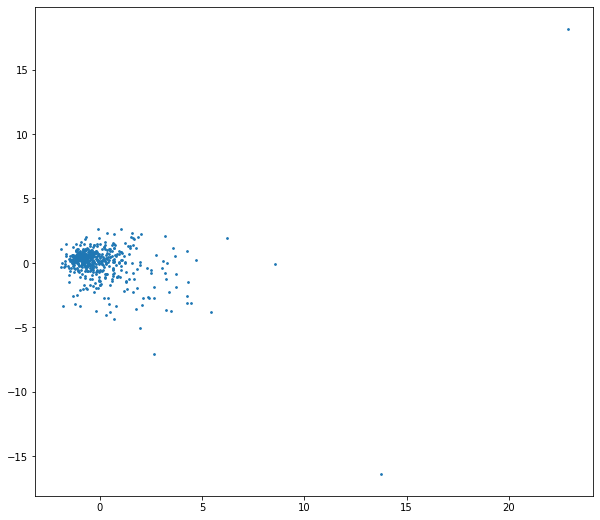

In [144]:
plt.figure(figsize=(10,9))
plt.scatter(vetorDoc_pca[:, 0], vetorDoc_pca[:, 1], s=3, cmap='Spectral')

In [145]:
x_train, x_test, y_train, y_test = train_test_split(vetorDoc_pca
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=1)

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


SENTIMENTO_label,0,1,2
row_0,,,
0,32,11,4
1,10,24,6
2,4,2,10


In [148]:
model = build_model(max_epochs=10, hs =0, dm = 1, vec_size=400, window = 1, alpha=0.03, text = w2v_total_data)

X = model[model.wv.vocab] #matriz de palavras
Y = model.docvecs.vectors_docs #matriz de intenções

#transforma em lista
vetorDoc = []
for i in range(0, len(Y)):
    vetorDoc.append(Y[i])


pca = PCA(n_components=0.99) #Explicar 99% da variância
pca.fit(vetorDoc)
vetorDoc_pca = pca.transform(vetorDoc)

x_train, x_test, y_train, y_test = train_test_split(vetorDoc_pca
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1, alpha=1)

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


SENTIMENTO_label,0,1,2
row_0,,,
0,31,8,4
1,10,24,7
2,5,5,9


In [149]:
model.wv.similar_by_word("respeito")

[("saudo']", 0.8397592306137085),
 ('profissionalismo', 0.8102535009384155),
 ("profissionalismo'", 0.7995865345001221),
 ("'aja", 0.7912088632583618),
 ('educacao', 0.7827285528182983),
 ("recarga']", 0.7762453556060791),
 ("'sinto", 0.7515881061553955),
 ('raiva', 0.71983802318573),
 ('"auxilio', 0.7164872884750366),
 ("funcao'", 0.7073705792427063)]

In [151]:
model.wv.similar_by_word("palhacada")

[("merda']", 0.830627977848053),
 ("['nem", 0.7997025847434998),
 ('votorantim', 0.7919848561286926),
 ("funcionalidade'", 0.7841161489486694),
 ("'agilizem", 0.7839767932891846),
 ('alocacao', 0.7769902348518372),
 ('virou', 0.7759866714477539),
 ('somente', 0.7737199068069458),
 ("data']", 0.7713992595672607),
 ("instabilidade'", 0.7700658440589905)]

In [152]:
model.wv.similar_by_word("demoram")

[('colocaram', 0.8260087370872498),
 ('poderiam', 0.8060516715049744),
 ('custa', 0.8053606748580933),
 ("'demoram", 0.8028307557106018),
 ("envie'", 0.7969196438789368),
 ("oh'", 0.7964017391204834),
 ("indevida'", 0.7929781675338745),
 ('coloquem', 0.7912800312042236),
 ('levar', 0.7889528274536133),
 ("falar'", 0.7871626615524292)]

In [155]:
model.wv.similar_by_word("horrivel")

[('pedindo', 0.7269002199172974),
 ("['onde", 0.6939099431037903),
 ('instalo', 0.6920100450515747),
 ('atividade', 0.6778377294540405),
 ("['ainda", 0.6762406229972839),
 ("dois'", 0.6749647855758667),
 ('nervoso', 0.6721662282943726),
 ('hein', 0.6701698303222656),
 ('conseguindo', 0.6658755540847778),
 ("'n", 0.6656349897384644)]

In [156]:
model.wv.similar_by_word("banco")

[('sistema', 0.7770317792892456),
 ('comprovante', 0.773215651512146),
 ('ano', 0.7689486742019653),
 ('endereco', 0.7624940276145935),
 ('whatsapp', 0.7223315834999084),
 ('vencida', 0.7184044718742371),
 ('cashback', 0.7161651253700256),
 ('direito', 0.704868495464325),
 ('servico', 0.7026729583740234),
 ('link', 0.6970478892326355)]

In [157]:
model.wv.similar_by_word("obrigada")

[('obrigado', 0.940455436706543),
 ("obrigada']", 0.9161301851272583),
 ("baguncado'", 0.8873982429504395),
 ("baixo'", 0.8638845682144165),
 ("'obrigado", 0.8551015853881836),
 ("almente'", 0.8544105291366577),
 ("['ok", 0.8531495332717896),
 ("'voltou*'", 0.8477998971939087),
 ('moca', 0.8430291414260864),
 ("obrigado'", 0.8425289392471313)]

In [158]:
model.wv.similar_by_word("excelente")

[("'tenha", 0.8473509550094604),
 ('tenha', 0.842308759689331),
 ('otimo', 0.8110674023628235),
 ('otima', 0.7967102527618408),
 ('dez', 0.7674165964126587),
 ('bom', 0.7601733207702637),
 ('somos', 0.7554494142532349),
 ('senti', 0.7413634061813354),
 ('saindo', 0.7361342310905457),
 ('atencao', 0.7180790901184082)]